In [38]:
import pandas as pd 
import numpy as np 
import yfinance as yf
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set_theme()

In [46]:
def get_logarithmic_returns(tickers: list, start: str, end: str)-> pd.DataFrame:
    data = yf.download(tickers=tickers, start=start, end=end)
    data = data["Adj Close"]
    data = pd.DataFrame(np.diff(np.log(data[1:]), axis=0) * 100, columns=data.columns)
    data = data.dropna(axis=0)
    return data

In [50]:
returns = get_logarithmic_returns(tickers=["AAPL", "GOOG", "BAS.DE", "BMW.DE", "RWE.DE", "DBK.DE"], start = "2010-01-01", end = "2018-12-31")

[*********************100%%**********************]  6 of 6 completed


Simulate random Portfolio

In [51]:
cov = np.cov(returns, rowvar=False)
returns = np.random.multivariate_normal([0, 0, 0, 0, 0, 0], cov, size=1000)


In [16]:
# from data

In [17]:
returns.shape

(2134, 6)

In [18]:
data.to_numpy()

array([[-1.60340277,  0.63194166,  1.53562748, -1.05119721, -2.55319372,
        -0.18989592],
       [-0.18504681, -0.66590326,  0.87997633,  0.44908356, -2.355474  ,
        -0.42493809],
       [ 0.66262174, -0.30620908, -1.3535186 ,  3.57830857,  1.32430346,
        -0.14694311],
       ...,
       [-2.55584024, -0.9825957 , -2.21634933, -7.29849413, -1.33833126,
        -0.857708  ],
       [-3.96723516,  1.61038603,  0.12521624,  0.59820995, -3.00382036,
        -0.31372192],
       [ 0.05123036,  1.21597312,  1.19524234,  3.1642168 , -0.65354941,
         2.53653565]])

In [19]:
# create random portfolio weights
PF_weights = np.random.rand(500,6)
PF_weights = PF_weights/PF_weights.sum(axis=1, keepdims=True)

In [20]:
# calculate PF Returns

In [21]:
temp_returns = PF_weights[0] * returns

In [22]:
temp_returns_overall = temp_returns.sum(axis=1)

In [23]:
temp_returns_overall

array([-0.58169686, -0.46141947,  0.43074722, ..., -2.02800819,
       -0.99019592,  1.25914946])

In [24]:
temp_returns_overall.std()

np.float64(1.2536860545855546)

In [25]:
def calculate_pf_returns(PF_weight, returns):
    temp_returns_overall2 = (PF_weight * returns).sum(axis=1)
    temp_mean = temp_returns_overall2.mean()
    temp_std = temp_returns_overall2.std()
    return temp_mean, temp_std


In [26]:
calculate_pf_returns(PF_weight=PF_weights[0], returns=returns)

(np.float64(0.008300054361417753), np.float64(1.2536860545855546))

In [27]:
simulated_mu_sigma = np.empty((500,2))
for i in range(0, len(PF_weights)):
    simulated_mu_sigma[i] = calculate_pf_returns(PF_weight=PF_weights[i], returns=returns)

In [28]:
simulated_mu_sigma

array([[ 8.30005436e-03,  1.25368605e+00],
       [ 1.67997905e-02,  1.21391066e+00],
       [ 9.24532476e-04,  1.42007614e+00],
       [ 1.63794210e-02,  1.27757216e+00],
       [-7.25651770e-04,  1.29514624e+00],
       [ 1.12576828e-02,  1.22156540e+00],
       [ 1.44399422e-02,  1.25991158e+00],
       [-4.46913862e-03,  1.39605894e+00],
       [ 5.87254550e-03,  1.26856345e+00],
       [ 2.77365643e-02,  1.22438115e+00],
       [ 2.03794376e-02,  1.20700458e+00],
       [-7.59859963e-03,  1.39283428e+00],
       [ 1.30015799e-02,  1.28876750e+00],
       [ 1.56254809e-02,  1.19638697e+00],
       [ 4.43096967e-03,  1.28705768e+00],
       [ 1.18456318e-02,  1.24108110e+00],
       [ 8.29609670e-03,  1.31821998e+00],
       [-5.71125748e-03,  1.35221199e+00],
       [ 5.08394960e-03,  1.25562839e+00],
       [-6.37607350e-03,  1.40045113e+00],
       [ 2.55869288e-02,  1.20007777e+00],
       [ 1.00685381e-03,  1.43449838e+00],
       [ 2.47508276e-02,  1.25698403e+00],
       [-3.

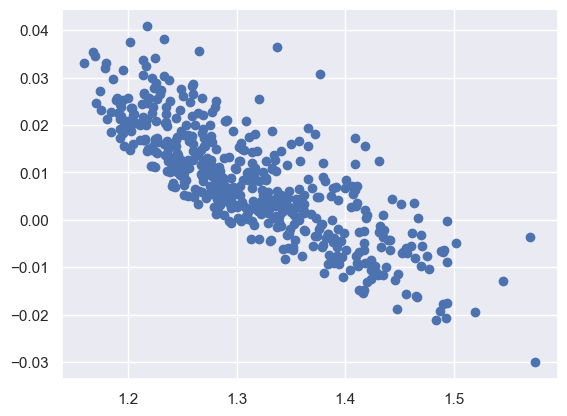

In [29]:
plt.scatter(x = simulated_mu_sigma[:,1], y = simulated_mu_sigma[:,0])

(-0.05, 0.05)

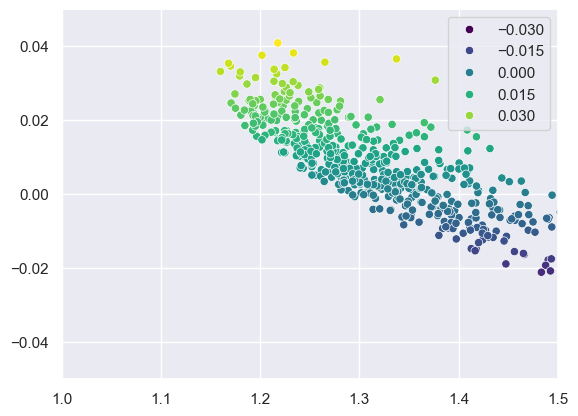

In [30]:
sns.scatterplot(x = simulated_mu_sigma[:,1], y = simulated_mu_sigma[:,0], palette='viridis', hue=simulated_mu_sigma[:,0])
plt.xlim(1,1.5)
plt.ylim(-0.05, 0.05)